# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import warnings

# warnings.filterwarnings("ignore")
from ast import literal_eval
import json
import os
from pathlib import Path
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

from typing import List, Dict
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/scratch/tmp.53890420.kevidu/ipykernel_124031/3757544002.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pan

In [3]:
# IMPORTANT: Run as if from project root so that imports work.
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(pardir)
os.getcwd()

'/cluster/work/cotterell/kdu/measureLM'

In [4]:
from analysis.analysis_helpers import (
    add_val_df_to_wandb,
    construct_df_given_query_id,
    load_val_df_from_wandb,
    permutation_test,
    percent_ents_passing_pscore_permutation_test,
    convert_entity_uri_to_entity,
)
from preprocessing.datasets import YagoECQ
from preprocessing.utils import extract_name_from_yago_uri
from utils import load_artifact_from_wandb, construct_paths_and_dataset_kwargs

### Preamble

'Bitstream Vera Sans'

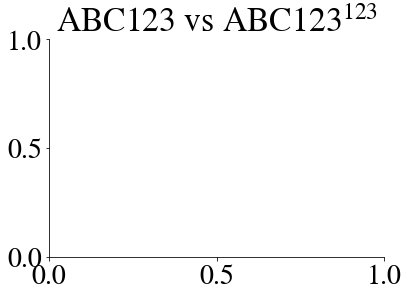

In [41]:
from mpl_styles import *
import matplotlib
import seaborn as sns

matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"

matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
ENTITY_COLOR = palette[0]
CONTEXT_COLOR = palette[1]

OPEN_COLOR = palette[2]
CLOSED_COLOR = palette[3]
LINE_COLOR = palette[7]

REAL_COLOR = palette[5]
FAKE_COLOR = palette[7]
DIFF_COLOR = palette[6]

matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")
matplotlib.rcParams["mathtext.rm"]

In [6]:
##############
# Parameters #
##############
CONFIG_PATH = "analysis/config-s11.yml"

In [7]:
# Data parameters
with open(CONFIG_PATH) as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
DATASET_NAME = config["DATASET_NAME"]
RAW_DATA_PATH = config["RAW_DATA_PATH"]
SEED = config["SEED"]
MODEL_ID = config["MODEL_ID"]
LOAD_IN_8BIT = config["LOAD_IN_8BIT"]
MAX_CONTEXTS = config["MAX_CONTEXTS"]
MAX_ENTITIES = config["MAX_ENTITIES"]
CAP_PER_TYPE = config["CAP_PER_TYPE"]
ABLATE_OUT_RELEVANT_CONTEXTS = config["ABLATE_OUT_RELEVANT_CONTEXTS"]
UNIFORM_CONTEXTS = config["UNIFORM_CONTEXTS"]
DEDUPLICATE_ENTITIES = config["DEDUPLICATE_ENTITIES"]
ENTITY_SELECTION_FUNC_NAME = config["ENTITY_SELECTION_FUNC_NAME"]
ENTITY_TYPES = config["ENTITY_TYPES"]
QUERY_TYPES = config["QUERY_TYPES"]
CONTEXT_TYPES = config["CONTEXT_TYPES"]
ANSWER_MAP = config["ANSWER_MAP"]

In [8]:
MODEL_ID, LOAD_IN_8BIT = "EleutherAI/pythia-70m-deduped", False
# MODEL_ID, LOAD_IN_8BIT = "EleutherAI/pythia-410m-deduped", False
# MODEL_ID, LOAD_IN_8BIT = "EleutherAI/pythia-1.4b-deduped", False
# MODEL_ID, LOAD_IN_8BIT = "EleutherAI/pythia-2.8b-deduped", False
# MODEL_ID, LOAD_IN_8BIT = "EleutherAI/pythia-6.9b-deduped", False
# MODEL_ID, LOAD_IN_8BIT = "EleutherAI/pythia-12b-deduped", True

In [9]:
# Compile into DATASET_KWARGS
DATASET_KWARGS = dict(
    DATASET_NAME=DATASET_NAME,
    RAW_DATA_PATH=RAW_DATA_PATH,
    SEED=SEED,
    MODEL_ID=MODEL_ID,
    LOAD_IN_8BIT=LOAD_IN_8BIT,
    MAX_CONTEXTS=MAX_CONTEXTS,
    MAX_ENTITIES=MAX_ENTITIES,
    CAP_PER_TYPE=CAP_PER_TYPE,
    ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
    UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
    DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
    ENTITY_SELECTION_FUNC_NAME=ENTITY_SELECTION_FUNC_NAME,
    ENTITY_TYPES=ENTITY_TYPES,
    CONTEXT_TYPES=CONTEXT_TYPES,
    QUERY_TYPES=QUERY_TYPES,
    ANSWER_MAP=ANSWER_MAP,
)

In [10]:
# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis"]
LOG_DATASETS = True

os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join("analysis", "analysis-yago-kg.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    # mode="disabled",
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cluster/home/kevidu/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smalle

{'ENTITY_COLOR': [0.00392156862745098, 0.45098039215686275, 0.6980392156862745], 'CONTEXT_COLOR': [0.8705882352941177, 0.5607843137254902, 0.0196078431372549], 'OPEN_COLOR': [0.00784313725490196, 0.6196078431372549, 0.45098039215686275], 'CLOSED_COLOR': [0.8352941176470589, 0.3686274509803922, 0.0], 'LINE_COLOR': [0.5803921568627451, 0.5803921568627451, 0.5803921568627451], 'REAL_COLOR': [0.792156862745098, 0.5686274509803921, 0.3803921568627451], 'FAKE_COLOR': [0.5803921568627451, 0.5803921568627451, 0.5803921568627451], 'DIFF_COLOR': [0.984313725490196, 0.6862745098039216, 0.8941176470588236], 'CONFIG_PATH': 'analysis/config-s11.yml', 'DATASET_NAME': 'YagoECQ', 'RAW_DATA_PATH': 'data/YagoECQ/yago_qec.json', 'SEED': 11, 'MODEL_ID': 'EleutherAI/pythia-70m-deduped', 'LOAD_IN_8BIT': False, 'MAX_CONTEXTS': 600, 'MAX_ENTITIES': 100, 'CAP_PER_TYPE': False, 'ABLATE_OUT_RELEVANT_CONTEXTS': False, 'UNIFORM_CONTEXTS': True, 'DEDUPLICATE_ENTITIES': True, 'ENTITY_SELECTION_FUNC_NAME': 'top_entity

/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [11]:
# # Downloads yago_qec.json from wandb (if not already cached there)
# artifact, files = load_artifact_from_wandb(
#     f"{DATASET_NAME}-yago_qec",
#     save_dir=Path(RAW_DATA_PATH).parent,
# )
# artifact.name

In [12]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)

In [13]:
query_ids = list(yago_qec.keys())
for qid, v in list(yago_qec.items())[:10]:
    print(qid, len(v["entities"]), len(set(v["entities"])))

http://schema.org/about 954 947
http://schema.org/actor 1000 991
http://schema.org/address 1000 997
http://schema.org/administrates 998 798
http://schema.org/affiliation 994 962
http://schema.org/alumniOf 1000 999
http://schema.org/author 1000 997
http://schema.org/award 666 663
http://schema.org/birthDate 1000 999
http://schema.org/birthPlace 1000 1000


In [14]:
# Analysis dir
analysis_dir = os.path.join("analysis", DATASET_NAME, MODEL_ID)
os.makedirs(analysis_dir, exist_ok=True)
print(f"Analysis dir: {analysis_dir}")

Analysis dir: analysis/YagoECQ/EleutherAI/pythia-70m-deduped


In [15]:
# Set random seeds
np.random.seed(SEED)
random.seed(SEED)

### Load Data

In [16]:
construct_df_given_query_id(
    yago_qec=yago_qec,
    **DATASET_KWARGS,
    QUERY_ID="http://schema.org/actor",
    verbose=False,
    overwrite_df=True,
).info()

Computing val_df_per_qe for http://schema.org/actor.
Unable to find mr_results_path at data/YagoECQ/schema_actor/schema_actor-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/11/models/EleutherAI/pythia-70m-deduped/results/mr.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_actor/schema_actor-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/11/models/EleutherAI/pythia-70m-deduped/results/mr.csv'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   q_id                   400 non-null    object 
 1   query_form             400 non-null    object 
 2   entity                 400 non-null    object 
 3   answer                 400 non-null    object 
 4   conte

In [17]:
qid_to_val_df_per_qe = {
    query_id: construct_df_given_query_id(
        yago_qec=yago_qec,
        **DATASET_KWARGS,
        QUERY_ID=query_id,
        verbose=False,
        overwrite_df=False,
    )
    for query_id in tqdm(query_ids)
}

 19%|█▉        | 24/125 [01:28<06:19,  3.76s/it]

Computing val_df_per_qe for http://schema.org/gtin.
Unable to find file at data/YagoECQ/schema_gtin/schema_gtin-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/11/models/EleutherAI/pythia-70m-deduped/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_gtin/schema_gtin-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/11/models/EleutherAI/pythia-70m-deduped/results/val.csv'


 52%|█████▏    | 65/125 [04:13<04:22,  4.37s/it]

Computing val_df_per_qe for http://schema.org/url.
Unable to find file at data/YagoECQ/schema_url/schema_url-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/11/models/EleutherAI/pythia-70m-deduped/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_url/schema_url-mc600-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-CT_assertive_base_negation-ES_top_entity_uri_degree/11/models/EleutherAI/pythia-70m-deduped/results/val.csv'


100%|██████████| 125/125 [08:35<00:00,  4.12s/it]


In [18]:
print(
    "No results for:",
    {k for k in qid_to_val_df_per_qe if qid_to_val_df_per_qe[k] is None},
)
qid_to_val_df_per_qe = {k: v for k, v in qid_to_val_df_per_qe.items() if v is not None}

No results for: {'http://schema.org/gtin', 'http://schema.org/url'}


In [19]:
# Snapshot
val_df_per_qe = qid_to_val_df_per_qe["http://schema.org/lyricist"]
query_forms = val_df_per_qe["query_form"].unique()
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[3]].sort_values(
    "susceptibility_score"
).head()

,q_id,query_form,entity,answer,contexts,persuasion_scores,persuasion_scores_kl,type,susceptibility_score,entity_classes,query_type,relevant_context_inds,model_id
378,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(The Heliotrope Gallery,)",John Lennon,"[Definitely, a lyricist for 'A Twilight Aria' ...","[0.14100170135498047, 0.32004642486572266, -0....","[0.18263958054052845, 0.2316144789753354, 0.21...",gpt_fake_entities,0.167527,{'http://schema.org/CreativeWork': 0.740740740...,open,"[486, 487, 488, 489, 490, 491]",EleutherAI/pythia-70m-deduped
389,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(The Clockwork Odes,)",Lobzang Yeshe Tenzin Gyatso,"[Definitely, a lyricist for 'A Twilight Aria' ...","[-0.04802417755126953, 0.06577205657958984, -0...","[0.22414487906503752, 0.17344783259795815, 0.2...",gpt_fake_entities,0.187117,{'http://schema.org/CreativeWork': 0.740740740...,open,"[456, 457, 458, 459, 460, 461]",EleutherAI/pythia-70m-deduped
332,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Wish You Were Here,)",David Gilmour,"[Definitely, a lyricist for 'A Twilight Aria' ...","[-0.5271711349487305, -0.17539310455322266, -0...","[0.3461368152436171, 0.16982519604494997, 0.25...",entities,0.203879,{'http://schema.org/CreativeWork': 0.740740740...,open,"[588, 589, 590, 591, 592, 593]",EleutherAI/pythia-70m-deduped
360,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(The Azure Triumvirate,)",Klaus Meine,"[Definitely, a lyricist for 'A Twilight Aria' ...","[-0.01742410659790039, 0.06809091567993164, -0...","[0.26726254021365453, 0.3212449501774032, 0.30...",gpt_fake_entities,0.212385,{'http://schema.org/CreativeWork': 0.740740740...,open,"[426, 427, 428, 429, 430, 431]",EleutherAI/pythia-70m-deduped
381,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(The Beguiled Baron,)",Chynna Phillips,"[Definitely, a lyricist for 'A Twilight Aria' ...","[-0.10892391204833984, 0.24854660034179688, -0...","[0.2995774337090206, 0.23633572183285653, 0.22...",gpt_fake_entities,0.220094,{'http://schema.org/CreativeWork': 0.740740740...,open,"[432, 433, 434, 435, 436, 437]",EleutherAI/pythia-70m-deduped


In [20]:
pd.concat(list(qid_to_val_df_per_qe.values()))[
    [
        "q_id",
        "query_form",
        "entity",
        "answer",
        "type",
        "susceptibility_score",
        "entity_classes",
        "query_type",
    ]
].to_csv("sus_scores_all.csv", index=False)

### Optionally, filter out fake entities that appear in the training data

In [21]:
FAKE_ENT_PILE_FREQS_PATH = "data/YagoECQ/fake_ent_pile_freqs.csv"
FAKE_ENTITY_FREQ_THRESHOLD = (
    0  # filter out any fake entities with frequency greater than this
)
# FAKE_ENTITY_FREQ_THRESHOLD = np.inf # don't filter at all

df_fake_ent_freqs = pd.read_csv(FAKE_ENT_PILE_FREQS_PATH)
fake_ent_freqs_dict = df_fake_ent_freqs.set_index("entity")["frequency"].to_dict()
for qid, df in tqdm(qid_to_val_df_per_qe.items()):
    qid_to_val_df_per_qe[qid] = df[
        df.apply(
            lambda x: x["type"] == "entities"
            or fake_ent_freqs_dict.get(x["entity"][0], 0) <= FAKE_ENTITY_FREQ_THRESHOLD,
            axis=1,
        )
    ]

print([len(df) for df in qid_to_val_df_per_qe.values()])
# # df_fake_ent_freqs.info()
# sns.distplot(np.log(df_fake_ent_freqs["frequency"]))

100%|██████████| 123/123 [00:01<00:00, 91.56it/s]


[376, 392, 328, 320, 288, 312, 384, 312, 312, 312, 312, 392, 348, 312, 312, 284, 396, 336, 336, 388, 388, 296, 392, 336, 328, 312, 336, 344, 300, 396, 396, 312, 388, 376, 304, 300, 332, 376, 316, 388, 400, 396, 312, 324, 384, 312, 292, 320, 380, 400, 388, 308, 392, 316, 324, 392, 304, 336, 300, 348, 392, 312, 392, 300, 316, 304, 316, 316, 312, 308, 392, 372, 300, 312, 300, 392, 308, 300, 300, 312, 300, 300, 392, 312, 300, 312, 324, 300, 320, 300, 312, 312, 312, 300, 312, 308, 324, 320, 312, 328, 344, 312, 328, 344, 340, 392, 312, 328, 340, 392, 312, 328, 396, 332, 312, 300, 396, 300, 360, 392, 308, 292, 300]


### Susceptibility Score vs Relation-dependent Entity Degree

In [22]:
QID_TO_ENTITY_DEG_PATH = "data/YagoECQ/entity_uri_to_predicate_degree_path.json"
with open(QID_TO_ENTITY_DEG_PATH) as f:
    qid_to_entity_degree = json.load(f)

len(qid_to_entity_degree)

127

In [23]:
qid_ent_deg_df = pd.DataFrame(
    [
        (qid, entity_uri, degree)
        for qid, entity_to_degree in qid_to_entity_degree.items()
        for entity_uri, degree in entity_to_degree.items()
    ],
    columns=["q_id", "entity_uri", "qid_ent_degree"],
)

In [25]:
qid_ent_deg_df["entity"] = qid_ent_deg_df.apply(convert_entity_uri_to_entity, axis=1)
qid_ent_deg_df = qid_ent_deg_df.dropna()
qid_ent_deg_df["entity"] = qid_ent_deg_df["entity"].apply(lambda x: (x,))
qid_ent_deg_df["qid_ent_degree"] = pd.to_numeric(qid_ent_deg_df["qid_ent_degree"])

In [26]:
val_dfs_all = pd.concat(list(qid_to_val_df_per_qe.values()), axis=0)

In [27]:
val_dfs_with_deg = val_dfs_all.merge(qid_ent_deg_df, on=["q_id", "entity"])
val_dfs_with_deg["log_qid_ent_degree"] = val_dfs_with_deg["qid_ent_degree"].apply(
    np.log
)
val_dfs_with_deg

,q_id,query_form,entity,answer,contexts,persuasion_scores,persuasion_scores_kl,type,susceptibility_score,entity_classes,query_type,relevant_context_inds,model_id,entity_uri,qid_ent_degree,log_qid_ent_degree
0,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Crime and Punishment,)",anguish,"[Definitely, 'A Christmas Carol' is about Isra...","[0.04333066940307617, 0.2864084243774414, 0.23...","[0.23654992819031548, 0.06147735224624566, 0.0...",entities,0.078727,{'http://schema.org/CreativeWork': 0.586206896...,closed,"[102, 103, 104, 105, 106, 107]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/Crime_and_P...,2,0.693147
1,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Stranger Things,)",monster,"[Definitely, 'A Christmas Carol' is about Isra...","[0.22869491577148438, 0.3694901466369629, 0.05...","[0.2072897442686467, 0.11232347902345786, 0.07...",entities,0.086017,{'http://schema.org/CreativeWork': 0.586206896...,closed,"[342, 343, 344, 345, 346, 347]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/Stranger_Th...,3,1.098612
2,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Sleeping Beauty,)",prostitution,"[Definitely, 'A Christmas Carol' is about Isra...","[0.37679576873779297, 0.3405318260192871, 0.26...","[0.13167128913944287, 0.07938829101337914, 0.0...",entities,0.080618,{'http://schema.org/CreativeWork': 0.586206896...,closed,"[306, 307, 308, 309, 310, 311]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/Sleeping_Be...,1,0.000000
3,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Sleeping Beauty,)",prostitution,"[Definitely, 'A Christmas Carol' is about Isra...","[0.37679576873779297, 0.3405318260192871, 0.26...","[0.13167128913944287, 0.07938829101337914, 0.0...",entities,0.080618,{'http://schema.org/CreativeWork': 0.586206896...,closed,"[306, 307, 308, 309, 310, 311]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/Sleeping_Be...,4,1.386294
4,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,(Indiana Jones and the Kingdom of the Crystal ...,Cold War,"[Definitely, 'A Christmas Carol' is about Isra...","[0.28795623779296875, 0.1257486343383789, 0.14...","[0.10235214686042188, 0.05808626597382959, 0.0...",entities,0.071941,{'http://schema.org/CreativeWork': 0.586206896...,closed,"[162, 163, 164, 165, 166, 167]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/Indiana_Jon...,2,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24599,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Kansas,)",Missouri Route 92,"[Definitely, Altitude Allies is the terminus o...","[0.24401521682739258, 0.2400345802307129, 0.38...","[1.1983360036626622, 0.44452973681612196, 0.82...",entities,1.188834,{'http://schema.org/Organization': 0.404761904...,open,"[204, 205, 206, 207, 208, 209, 499]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/Kansas,19,2.944439
24600,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(West Virginia,)",Maryland Route 36,"[Definitely, Altitude Allies is the terminus o...","[-0.4600982666015625, 0.2925581932067871, 0.51...","[0.9197657067781517, 0.33635923320055944, 0.84...",entities,1.040702,{'http://schema.org/Organization': 0.404761904...,open,"[558, 559, 560, 561, 562, 563]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/West_Virginia,3,1.098612
24601,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Geneva,)",European route E21,"[Definitely, Altitude Allies is the terminus o...","[0.3190193176269531, 1.0661420822143555, 0.896...","[1.263285285911028, 0.4312504008759548, 1.0103...",entities,1.108027,{'http://schema.org/Organization': 0.404761904...,open,"[162, 163, 164, 165, 166, 167]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/Geneva,2,0.693147
24602,reverse-http://yago-knowledge.org/resourc

In [28]:
from scipy import stats as sst

sst.spearmanr(
    val_dfs_with_deg[val_dfs_with_deg["query_type"] == "open"][
        ["log_qid_ent_degree", "susceptibility_score"]
    ]
)

SpearmanrResult(correlation=0.07532088263401185, pvalue=6.001079205227533e-17)

In [29]:
val_dfs_with_deg[val_dfs_with_deg["query_type"] == "open"][
    ["log_qid_ent_degree", "susceptibility_score"]
].to_csv(
    os.path.join(analysis_dir, "log_qid_ent_deg_vs_sus_score_open.csv"), index=False
)

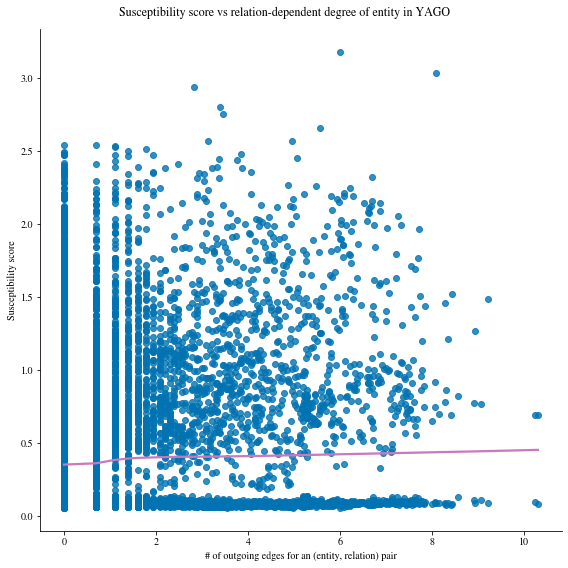

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
sns.regplot(
    data=val_dfs_with_deg[val_dfs_with_deg["query_type"] == "open"],
    x="log_qid_ent_degree",
    y="susceptibility_score",
    # log_scale=True,
    # hue="query_type",
    lowess=True,
    line_kws={"color": palette[4]},
    ax=ax,
)
ax.set_xlabel("# of outgoing edges for an (entity, relation) pair")
ax.set_ylabel("Susceptibility score")
fig.suptitle("Susceptibility score vs relation-dependent degree of entity in YAGO")
plt.tight_layout()
ax.set_ylim
plot_name = f"plot_susscore_vs_yago_qid_degree_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

In [31]:
val_dfs_with_deg.to_csv(os.path.join(analysis_dir, "val_dfs_with_deg.csv"), index=False)

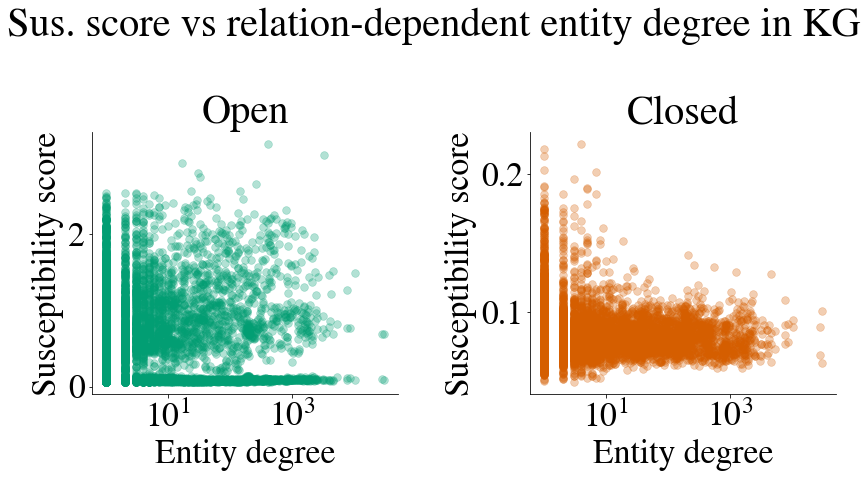

In [42]:
colormap = {"closed": CLOSED_COLOR, "open": OPEN_COLOR}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
scatter_kws = {"s": 60, "alpha": 0.3, "ec": None}

for i, qt in enumerate(reversed(val_dfs_with_deg["query_type"].unique())):
    ax = axes[i]
    sns.scatterplot(
        data=val_dfs_with_deg[val_dfs_with_deg["query_type"] == qt],
        x="qid_ent_degree",
        y="susceptibility_score",
        # hue="query_type",
        # size=10,
        # dodge=True,
        ax=ax,
        color=colormap[qt],
        legend=None,
        **scatter_kws,
    )
    ax.set_title(qt.capitalize(), size="x-large")
    ax.set_xlabel("Entity degree", size="large")
    ax.set_ylabel("Susceptibility score", size="large")
    ax.set_xscale("log")
    ax.tick_params(axis="both", which="major", labelsize="large")


fig.suptitle(
    "Sus. score vs relation-dependent entity degree in KG",
    # y=0.92,
    size="x-large",
)
plt.tight_layout()
plot_name = f"plot_susscore_vs_yago_qid_degree_both"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

### Susceptibility Score vs Entity Degree

In [33]:
### Entity degree (Query independent) ###
ENTITY_DEG_PATH = "data/YagoECQ/entity_uri_to_degree.json"
with open(ENTITY_DEG_PATH) as f:
    entity_degree = json.load(f)

len(entity_degree)

96272

In [34]:
ent_degree_df = pd.DataFrame(
    [(ent_uri, deg) for ent_uri, deg in entity_degree.items()],
    columns=["entity_uri", "degree"],
)
ent_degree_df

,entity_uri,degree
0,http://yago-knowledge.org/resource/Paul_McCartney,894
1,http://yago-knowledge.org/resource/Paul_Allen_...,34
2,http://yago-knowledge.org/resource/Bicaz,90
3,http://yago-knowledge.org/resource/1992_Chines...,16
4,http://yago-knowledge.org/resource/Jane_Arthur,27
...,...,...
96267,http://yago-knowledge.org/resource/Republic_of...,40
96268,http://yago-knowledge.org/resource/Banda_do_Mar,24
96269,http://yago-knowledge.org/resource/Society_for...,473
96270,http://yago-knowledge.org/resource/Interstate_...,19


In [35]:
ENTITY_NAME_TO_URI_PATH = "data/YagoECQ/entity_name_to_possible_entity_uris.json"

with open(ENTITY_NAME_TO_URI_PATH) as f:
    entity_name_to_uri = json.load(f)
e_uri_to_name = {
    e_uri: entity_name
    for entity_name, e_uris in entity_name_to_uri.items()
    for e_uri in e_uris
}
len(e_uri_to_name)

ENTITY_URI_TO_NAME_PATH = "data/YagoECQ/entity_uri_to_name.json"
with open(ENTITY_URI_TO_NAME_PATH, "w", encoding="utf-8") as fp:
    json.dump(e_uri_to_name, fp, ensure_ascii=False, indent=4)

In [36]:
def convert_entity_uri_to_entity2(row: pd.Series):
    try:
        return e_uri_to_name[row["entity_uri"]]
    except (KeyError, ValueError):
        return None

In [37]:
ent_degree_df["entity"] = ent_degree_df.apply(convert_entity_uri_to_entity2, axis=1)
ent_degree_df = ent_degree_df.dropna()
ent_degree_df["entity"] = ent_degree_df["entity"].apply(lambda x: (x,))
ent_degree_df["degree"] = pd.to_numeric(ent_degree_df["degree"])
ent_degree_df

/scratch/tmp.53890420.kevidu/ipykernel_124031/2163315234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ent_degree_df["entity"] = ent_degree_df["entity"].apply(lambda x: (x,))
/scratch/tmp.53890420.kevidu/ipykernel_124031/2163315234.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ent_degree_df["degree"] = pd.to_numeric(ent_degree_df["degree"])


,entity_uri,degree,entity
0,http://yago-knowledge.org/resource/Paul_McCartney,894,"(Paul McCartney,)"
1,http://yago-knowledge.org/resource/Paul_Allen_...,34,"(Paul Allen,)"
2,http://yago-knowledge.org/resource/Bicaz,90,"(Bicaz,)"
3,http://yago-knowledge.org/resource/1992_Chines...,16,"(Chinese Jia-A League 1992,)"
4,http://yago-knowledge.org/resource/Jane_Arthur,27,"(Jane Arthur,)"
...,...,...,...
96267,http://yago-knowledge.org/resource/Republic_of...,40,"(Republic of Tarnobrzeg,)"
96268,http://yago-knowledge.org/resource/Banda_do_Mar,24,"(Banda do Mar,)"
96269,http://yago-knowledge.org/resource/Society_for...,473,"(Society for Industrial and Applied Mathematics,)"
96270,http://yago-knowledge.org/resource/Interstate_...,19,"(Interstate 80 Business,)"


In [38]:
val_dfs_with_ent_deg = val_dfs_all.merge(ent_degree_df, on=["entity"])
val_dfs_with_ent_deg["log_degree"] = val_dfs_with_ent_deg["degree"].apply(np.log)
val_dfs_with_ent_deg

,q_id,query_form,entity,answer,contexts,persuasion_scores,persuasion_scores_kl,type,susceptibility_score,entity_classes,query_type,relevant_context_inds,model_id,entity_uri,degree,log_degree
0,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Crime and Punishment,)",anguish,"[Definitely, 'A Christmas Carol' is about Isra...","[0.04333066940307617, 0.2864084243774414, 0.23...","[0.23654992819031548, 0.06147735224624566, 0.0...",entities,0.078727,{'http://schema.org/CreativeWork': 0.586206896...,closed,"[102, 103, 104, 105, 106, 107]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/Crime_and_P...,89,4.488636
1,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Crime and Punishment,)",anguish,"[Definitely, 'A Christmas Carol' is about Isra...","[0.04333066940307617, 0.2864084243774414, 0.23...","[0.23654992819031548, 0.06147735224624566, 0.0...",entities,0.078727,{'http://schema.org/CreativeWork': 0.586206896...,closed,"[102, 103, 104, 105, 106, 107]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/Crime_and_P...,294,5.683580
2,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Crime and Punishment,)",anguish,"[Definitely, 'A Christmas Carol' is about Isra...","[0.04333066940307617, 0.2864084243774414, 0.23...","[0.23654992819031548, 0.06147735224624566, 0.0...",entities,0.078727,{'http://schema.org/CreativeWork': 0.586206896...,closed,"[102, 103, 104, 105, 106, 107]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/Crime_and_P...,57,4.043051
3,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Stranger Things,)",monster,"[Definitely, 'A Christmas Carol' is about Isra...","[0.22869491577148438, 0.3694901466369629, 0.05...","[0.2072897442686467, 0.11232347902345786, 0.07...",entities,0.086017,{'http://schema.org/CreativeWork': 0.586206896...,closed,"[342, 343, 344, 345, 346, 347]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/Stranger_Th...,264,5.575949
4,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Sleeping Beauty,)",prostitution,"[Definitely, 'A Christmas Carol' is about Isra...","[0.37679576873779297, 0.3405318260192871, 0.26...","[0.13167128913944287, 0.07938829101337914, 0.0...",entities,0.080618,{'http://schema.org/CreativeWork': 0.586206896...,closed,"[306, 307, 308, 309, 310, 311]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/Sleeping_Be...,96,4.564348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26123,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Geneva,)",European route E21,"[Definitely, Altitude Allies is the terminus o...","[0.3190193176269531, 1.0661420822143555, 0.896...","[1.263285285911028, 0.4312504008759548, 1.0103...",entities,1.108027,{'http://schema.org/Organization': 0.404761904...,open,"[162, 163, 164, 165, 166, 167]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/Geneva,2531,7.836370
26124,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Geneva,)",European route E21,"[Definitely, Altitude Allies is the terminus o...","[0.3190193176269531, 1.0661420822143555, 0.896...","[1.263285285911028, 0.4312504008759548, 1.0103...",entities,1.108027,{'http://schema.org/Organization': 0.404761904...,open,"[162, 163, 164, 165, 166, 167]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/Geneva_u002...,136,4.912655
26125,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Geneva,)",European route E21,"[Definitely, Altitude Allies is the terminus o...","[0.3190193176269531, 1.0661420822143555, 0.896...","[1.263285285911028, 0.4312504008759548, 1.0103...",entities,1.108027,{'http://schema.org/Organization': 0.404761904...,open,"[162, 163, 164, 165, 166, 167]",EleutherAI/pythia-70m-deduped,http://yago-knowledge.org/resource/Geneva_u002...,64,4.158883
26126,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the termi

In [39]:
from scipy import stats as sst

sst.spearmanr(
    val_dfs_with_ent_deg[val_dfs_with_ent_deg["query_type"] == "open"][
        ["log_degree", "susceptibility_score"]
    ]
)

SpearmanrResult(correlation=0.05160631679653171, pvalue=3.594271161095776e-09)

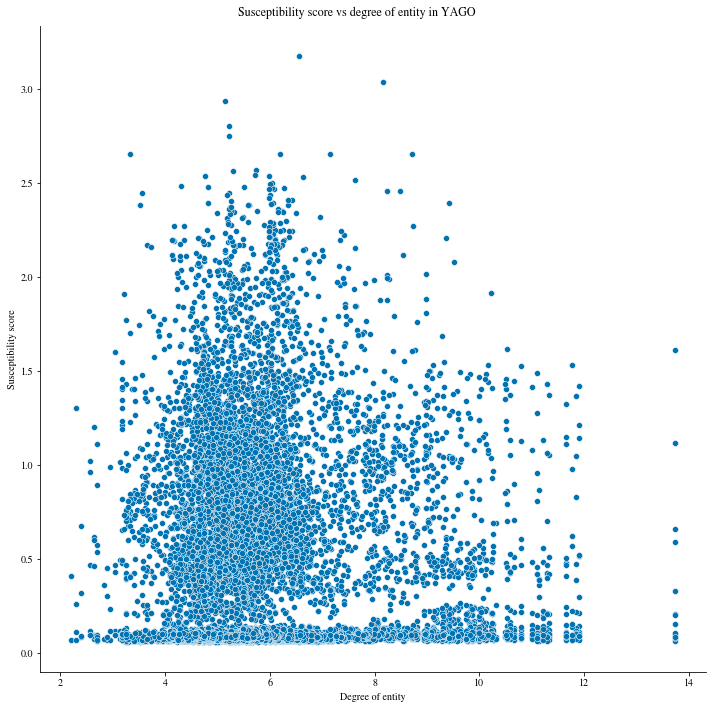

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.scatterplot(
    data=val_dfs_with_ent_deg[val_dfs_with_ent_deg["query_type"] == "open"],
    x="log_degree",
    y="susceptibility_score",
)
ax.set_xlabel("Degree of entity")
ax.set_ylabel("Susceptibility score")
fig.suptitle("Susceptibility score vs degree of entity in YAGO")
plt.tight_layout()
plot_name = f"plot_susscore_vs_yago_degree_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")